In [1]:
# -*- coding: utf-8 -*-
"""collaborative filtering models

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1cgXJ45i7SZkwEuJZ_CrqNnRl9GxnFqaR
"""

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/data/MovieLens/'

ratings = pd.read_csv(path + 'ratings.dat', sep='::', engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

movies = pd.read_csv(path + 'movies.dat', sep='::', engine='python',
                     names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

users = pd.read_csv(path + 'users.dat', sep='::', engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])



Mounted at /content/drive


In [2]:
# Display sample data
ratings.head()



,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movies.head()



,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
users.head()



,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
# Check for missing values in each dataframe
print("Missing values in ratings:")
print(ratings.isnull().sum())

print("\nMissing values in movies:")
print(movies.isnull().sum())

print("\nMissing values in users:")
print(users.isnull().sum())



Missing values in ratings:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Missing values in movies:
MovieID    0
Title      0
Genres     0
dtype: int64

Missing values in users:
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


In [6]:
# Genres column has multiple genres per movie separated by |
from sklearn.preprocessing import MultiLabelBinarizer

# Split genres
movies['Genres'] = movies['Genres'].apply(lambda x: x.split('|'))

# Binarize
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(movies['Genres']),
                             columns=mlb.classes_,
                             index=movies.index)

# Concatenate back to movies
movies = pd.concat([movies.drop('Genres', axis=1), genre_encoded], axis=1)

movies.head()



,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Identify numerical columns in ratings dataframe
numerical_cols_ratings = ratings.select_dtypes(include=['int64', 'float64']).columns

print("Numerical columns in ratings dataframe:", numerical_cols_ratings)

# Apply IQR method to each numerical column in ratings dataframe
for col in numerical_cols_ratings:
    Q1 = ratings[col].quantile(0.25)
    Q3 = ratings[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ratings[(ratings[col] < lower_bound) | (ratings[col] > upper_bound)]

    print(f"\nOutliers in '{col}' column of ratings dataframe:")
    if outliers.empty:
        print("No outliers found.")
    else:
        print(outliers)

#Labelencoding

le_gender = LabelEncoder()
users['Gender'] = le_gender.fit_transform(users['Gender'])  # M=1, F=0

users.head()


Numerical columns in ratings dataframe: Index(['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype='object')

Outliers in 'UserID' column of ratings dataframe:
No outliers found.

Outliers in 'MovieID' column of ratings dataframe:
No outliers found.

Outliers in 'Rating' column of ratings dataframe:
         UserID  MovieID  Rating  Timestamp
148           2       21       1  978299839
180           2     3893       1  978299535
205           3     1261       1  978297663
249           4     3527       1  978294008
268           5     2916       1  978245645
...         ...      ...     ...        ...
1000171    6040     3388       1  956716407
1000177    6040     2751       1  956716438
1000185    6040     2794       1  956716438
1000187    6040     2003       1  956716294
1000204    6040     1091       1  956716541

[56174 rows x 4 columns]

Outliers in 'Timestamp' column of ratings dataframe:
         UserID  MovieID  Rating   Timestamp
2327         19      318       4   994556598
24

,UserID,Gender,Age,Occupation,Zip-code
0,1,0,1,10,48067
1,2,1,56,16,70072
2,3,1,25,15,55117
3,4,1,45,7,02460
4,5,1,25,20,55455


In [8]:
#Embedding on title column
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
title_embeddings = tfidf.fit_transform(movies['Title'])

# Assign ratings to ratings_filtered as it was not defined
ratings_filtered = ratings

user_item_matrix = ratings_filtered.pivot_table(index='UserID', columns='MovieID', values='Rating')

print("\nUser-Item Matrix Head:")
display(user_item_matrix.head())

from sklearn.model_selection import train_test_split

train_ratings, test_ratings = train_test_split(ratings_filtered, test_size=0.2, random_state=42)

print("\nShape of training ratings:", train_ratings.shape)
print("Shape of testing ratings:", test_ratings.shape)

# create training and testing user-item matrices from these split dataframes.
train_user_item_matrix = train_ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')
test_user_item_matrix = test_ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Align the columns (MovieIDs) and indices (UserIDs) of train and test matrices
train_user_item_matrix = train_user_item_matrix.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns)
test_user_item_matrix = test_user_item_matrix.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns)

print("\nShape of training user-item matrix:", train_user_item_matrix.shape)
print("Shape of testing user-item matrix:", test_user_item_matrix.shape)

"""#CF User-Based & Item-Based Model"""

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine # For similarity calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create User-Item Matrices (using sparse matrices):
from scipy.sparse import csr_matrix

# Get unique users and movies to create mappings
all_users = sorted(list(ratings_filtered['UserID'].unique()))
all_movies = sorted(list(ratings_filtered['MovieID'].unique()))
user_to_index = {user: i for i, user in enumerate(all_users)}
movie_to_index = {movie: i for i, movie in enumerate(all_movies)}

# Create sparse matrix for training data
train_rows = train_ratings['UserID'].map(user_to_index)
train_cols = train_ratings['MovieID'].map(movie_to_index)
train_values = train_ratings['Rating']

# Build the training user-item matrix (CSR format is good for row-based operations)
train_user_item_matrix = csr_matrix((train_values, (train_rows, train_cols)),
                                     shape=(len(all_users), len(all_movies)))

# Create a similar sparse matrix for the test data (for evaluation)
test_rows = test_ratings['UserID'].map(user_to_index)
test_cols = test_ratings['MovieID'].map(movie_to_index)
test_values = test_ratings['Rating']

test_user_item_matrix = csr_matrix((test_values, (test_rows, test_cols)),
                                    shape=(len(all_users), len(all_movies)))

print("Shape of training user-item sparse matrix:", train_user_item_matrix.shape)
print("Shape of testing user-item sparse matrix:", test_user_item_matrix.shape)


User-Item Matrix Head:


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Shape of training ratings: (800167, 4)
Shape of testing ratings: (200042, 4)

Shape of training user-item matrix: (6040, 3706)
Shape of testing user-item matrix: (6040, 3706)
Shape of training user-item sparse matrix: (6040, 3706)
Shape of testing user-item sparse matrix: (6040, 3706)


In [9]:
# Implement User-based Collaborative Filtering:
def user_based_prediction(user_id, movie_id, train_matrix, user_sim_matrix, k=30):
    """Predicts the rating of a user for a movie using User-based CF."""
    user_idx = user_to_index[user_id]
    movie_idx = movie_to_index[movie_id]

    # Get the similarity scores of the target user with all other users
    user_similarities = user_sim_matrix[user_idx, :]

    # Find users who have rated the target movie
    users_who_rated_movie_indices = train_matrix[:, movie_idx].nonzero()[0]

    # Filter similarities to only include users who rated the target movie
    relevant_user_similarities = user_similarities[users_who_rated_movie_indices]
    relevant_user_indices = users_who_rated_movie_indices

    # Get the ratings of the target movie by these users
    relevant_user_ratings = train_matrix[relevant_user_indices, movie_idx].toarray().flatten()

    # Combine similarities and ratings
    similarity_rating_pairs = list(zip(relevant_user_similarities, relevant_user_ratings))

    # Sort by similarity in descending order and take top K
    similarity_rating_pairs.sort(key=lambda x: x[0], reverse=True)
    top_k_similar_users = similarity_rating_pairs[:k]

    # Calculate the weighted average
    numerator = sum(sim * rating for sim, rating in top_k_similar_users if sim > 0) # Only consider positive similarities
    denominator = sum(abs(sim) for sim, _ in top_k_similar_users if sim > 0)

    if denominator == 0:
        # If no similar users or no positive similarities, predict the average rating
        return np.mean(train_matrix.data) # Using mean of all ratings in training data
    else:
        return numerator / denominator

# Get user vectors from the training matrix
user_vectors = train_user_item_matrix



In [10]:
# Calculate pairwise cosine similarity between users
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_matrix = cosine_similarity(user_vectors)

print("Shape of user similarity matrix:", user_similarity_matrix.shape)


# Predictions for User-based CF
user_based_predictions = []
for index, row in test_ratings.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']

    predicted_rating = user_based_prediction(user_id, movie_id, train_user_item_matrix, user_similarity_matrix)
    user_based_predictions.append((user_id, movie_id, true_rating, predicted_rating))

# Convert predictions to a DataFrame for easier evaluation
user_based_predictions_df = pd.DataFrame(user_based_predictions, columns=['UserID', 'MovieID', 'TrueRating', 'PredictedRating'])



Shape of user similarity matrix: (6040, 6040)


In [11]:
# Implement Item-based Collaborative Filtering:
def item_based_prediction(user_id, movie_id, train_matrix, item_sim_matrix, k=30):
    """Predicts the rating of a user for a movie using Item-based CF."""
    user_idx = user_to_index[user_id]
    movie_idx = movie_to_index[movie_id]

    # Get the similarity scores of the target movie with all other movies
    item_similarities = item_sim_matrix[movie_idx, :]

    # Find movies that the target user has rated
    movies_rated_by_user_indices = train_matrix[user_idx, :].nonzero()[1]

    # Filter similarities to only include movies rated by the target user
    relevant_item_similarities = item_similarities[movies_rated_by_user_indices]
    relevant_item_indices = movies_rated_by_user_indices

    # Get the ratings of these movies by the target user
    relevant_item_ratings = train_matrix[user_idx, relevant_item_indices].toarray().flatten()

    # Combine similarities and ratings
    similarity_rating_pairs = list(zip(relevant_item_similarities, relevant_item_ratings))

    # Sort by similarity in descending order and take top K
    similarity_rating_pairs.sort(key=lambda x: x[0], reverse=True)
    top_k_similar_items = similarity_rating_pairs[:k]

    # Calculate the weighted average
    numerator = sum(sim * rating for sim, rating in top_k_similar_items if sim > 0) # Only consider positive similarities
    denominator = sum(abs(sim) for sim, _ in top_k_similar_items if sim > 0)

    if denominator == 0:
        # If no similar items or no positive similarities, predict the average rating
        return np.mean(train_matrix.data) # Using mean of all ratings in training data
    else:
        return numerator / denominator


#  Calculate Item Similarity Matrix


# Get item vectors (transpose the user-item matrix)
item_vectors = train_user_item_matrix.T

# Calculate pairwise cosine similarity between items
item_similarity_matrix = cosine_similarity(item_vectors)

print("Shape of item similarity matrix:", item_similarity_matrix.shape)




Shape of item similarity matrix: (3706, 3706)


In [12]:
#  Predictions for Item-based CF
item_based_predictions = []
for index, row in test_ratings.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    true_rating = row['Rating']

    predicted_rating = item_based_prediction(user_id, movie_id, train_user_item_matrix, item_similarity_matrix)
    item_based_predictions.append((user_id, movie_id, true_rating, predicted_rating))

# Convert predictions to a DataFrame for evaluation
item_based_predictions_df = pd.DataFrame(item_based_predictions, columns=['UserID', 'MovieID', 'TrueRating', 'PredictedRating'])

#  Evaluate Models (RMSE and MAE):
# Calculate RMSE and MAE for User-based CF
user_based_rmse = np.sqrt(mean_squared_error(user_based_predictions_df['TrueRating'], user_based_predictions_df['PredictedRating']))
user_based_mae = mean_absolute_error(user_based_predictions_df['TrueRating'], user_based_predictions_df['PredictedRating'])

print(f"\nUser-based CF Model Evaluation:")
print(f"RMSE: {user_based_rmse}")
print(f"MAE: {user_based_mae}")




User-based CF Model Evaluation:
RMSE: 0.9647741062988463
MAE: 0.7682909856133573


In [13]:
# Calculate RMSE and MAE for Item-based CF
item_based_rmse = np.sqrt(mean_squared_error(item_based_predictions_df['TrueRating'], item_based_predictions_df['PredictedRating']))
item_based_mae = mean_absolute_error(item_based_predictions_df['TrueRating'], item_based_predictions_df['PredictedRating'])

print(f"\nItem-based CF Model Evaluation:")
print(f"RMSE: {item_based_rmse}")
print(f"MAE: {item_based_mae}")




Item-based CF Model Evaluation:
RMSE: 0.940285433964063
MAE: 0.7336171116451512



Model Metrics Comparison:


,Model,RMSE,MAE
0,User-based CF,0.964774,0.768291
1,Item-based CF,0.940285,0.733617


<ipython-input-21-7834450a2270>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=metrics_df, palette='viridis')
<ipython-input-21-7834450a2270>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=metrics_df, palette='viridis')


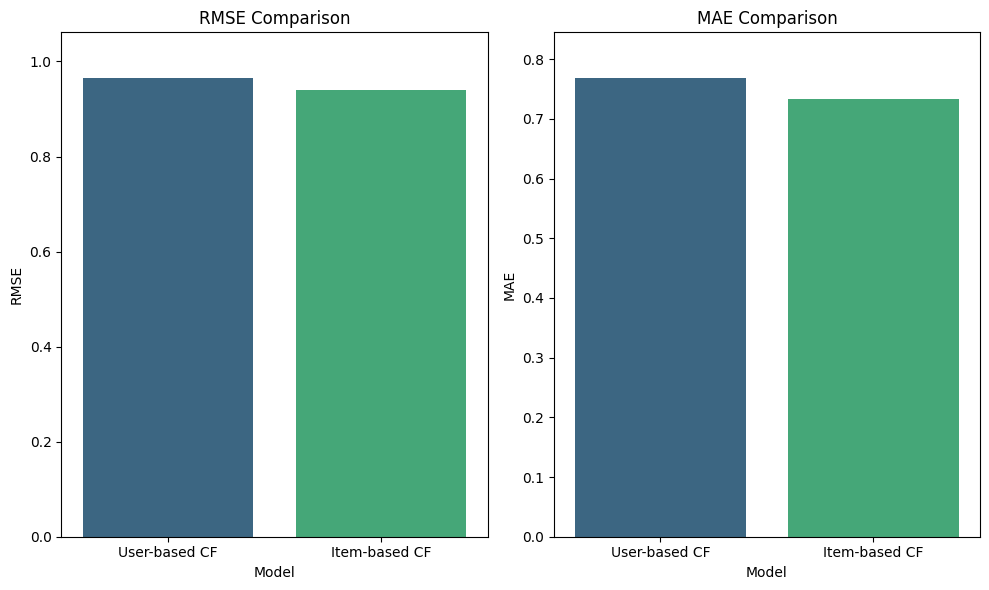

In [21]:


import pandas as pd
import matplotlib.pyplot as plt
# Visualize the comparison
metrics_data = {
    'Model': ['User-based CF', 'Item-based CF'],
    'RMSE': [user_based_rmse, item_based_rmse],
    'MAE': [user_based_mae, item_based_mae]
}
metrics_df = pd.DataFrame(metrics_data)

print("\nModel Metrics Comparison:")
display(metrics_df)

plt.figure(figsize=(10, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=metrics_df, palette='viridis')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.ylim(0, max(metrics_df['RMSE']) * 1.1) # Set y-limit for better comparison

# Plot MAE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MAE', data=metrics_df, palette='viridis')
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.ylim(0, max(metrics_df['MAE']) * 1.1) # Set y-limit for better comparison

plt.tight_layout()
plt.show()

In [14]:
from collections import defaultdict

def get_top_n_predictions(predictions_df, n=10):
    """Get the top-N predicted items for each user."""
    top_n = defaultdict(list)
    for index, row in predictions_df.iterrows():
        uid = row['UserID']
        iid = row['MovieID']
        est_r = row['PredictedRating']
        true_r = row['TrueRating']
        top_n[uid].append((iid, est_r, true_r))

    # Sort predictions for each user by estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def calculate_precision_at_k(top_n_predictions, threshold=3.5):
    """Calculates the average Precision@K."""
    precisions = []
    for uid, user_ratings in top_n_predictions.items():
        n_recommended = len(user_ratings)
        n_relevant_and_recommended = sum(1 for (iid, est_r, true_r) in user_ratings if true_r >= threshold)

        if n_recommended > 0:
            precisions.append(n_relevant_and_recommended / n_recommended)

    if len(precisions) == 0:
        return 0
    return sum(precisions) / len(precisions)




In [15]:
# Get top-10 predictions for each user in the test set
top_10_user_based = get_top_n_predictions(user_based_predictions_df, n=10)
top_10_item_based = get_top_n_predictions(item_based_predictions_df, n=10)

# Set the relevance threshold
relevance_threshold = 4 # Or 3.5 as you used before

# Calculate Precision@10 for both models
precision_at_10_user = calculate_precision_at_k(top_10_user_based, threshold=relevance_threshold)
precision_at_10_item = calculate_precision_at_k(top_10_item_based, threshold=relevance_threshold)

print(f"\nUser-based CF Model Precision@10 (Threshold >= {relevance_threshold}): {precision_at_10_user}")
print(f"Item-based CF Model Precision@10 (Threshold >= {relevance_threshold}): {precision_at_10_item}")




User-based CF Model Precision@10 (Threshold >= 4): 0.7471825922596149
Item-based CF Model Precision@10 (Threshold >= 4): 0.7392163782814754


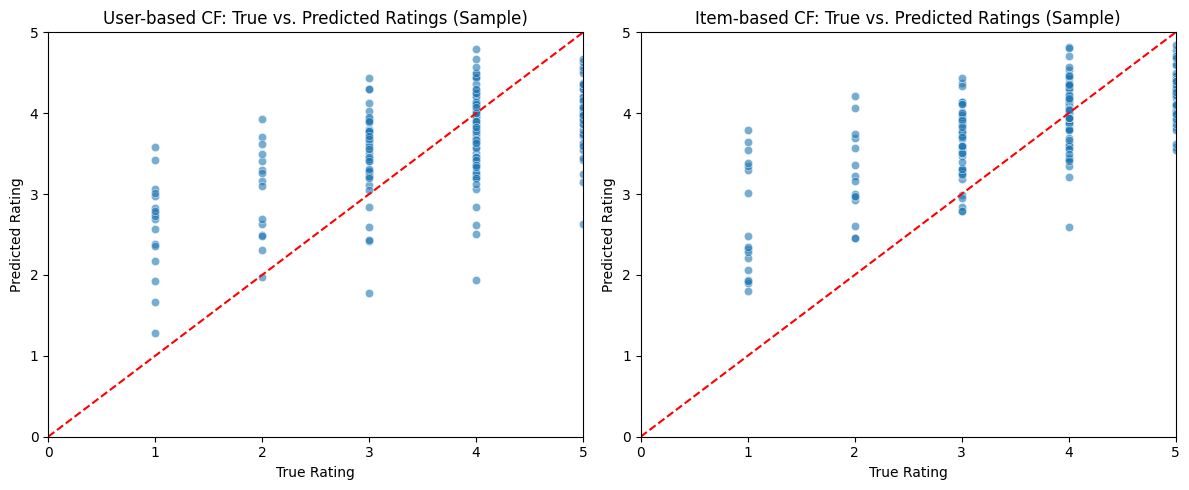

In [16]:
# Take a sample of predictions for visualization
sample_predictions_user = user_based_predictions_df.sample(n=200, random_state=42)
sample_predictions_item = item_based_predictions_df.sample(n=200, random_state=42)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='TrueRating', y='PredictedRating', data=sample_predictions_user, alpha=0.6)
plt.title('User-based CF: True vs. Predicted Ratings (Sample)')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.plot([0, 5], [0, 5], color='red', linestyle='--') # Ideal line

plt.subplot(1, 2, 2)
sns.scatterplot(x='TrueRating', y='PredictedRating', data=sample_predictions_item, alpha=0.6)
plt.title('Item-based CF: True vs. Predicted Ratings (Sample)')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.plot([0, 5], [0, 5], color='red', linestyle='--') # Ideal line

plt.tight_layout()
plt.show()



In [17]:
# Example for User-based CF
# Select a sample user and their top K similar users
sample_user_id = user_based_predictions_df['UserID'].iloc[0]
user_idx = user_to_index[sample_user_id]
user_similarities = user_similarity_matrix[user_idx, :]

# Get indices of top similar users (excluding the user themselves)
top_k = 5
similar_user_indices = np.argsort(user_similarities)[::-1][1:top_k+1]
similar_user_ids = [all_users[i] for i in similar_user_indices]

print(f"Sample User: {sample_user_id}")
print(f"Top {top_k} Similar Users: {similar_user_ids}")



Sample User: 5412
Top 5 Similar Users: [np.int64(3101), np.int64(5880), np.int64(716), np.int64(3654), np.int64(1246)]


In [18]:
# Get the ratings of the sample user and similar users for some movies
# Select some movies the sample user or similar users have rated
movies_rated_by_sample_user = train_user_item_matrix[user_idx, :].nonzero()[1]
# You might select a subset of these for visualization
sample_movie_indices = movies_rated_by_sample_user[:10] # Take first 10 rated movies

print("\nRatings of Sample User and Similar Users for a few movies:")
rating_data = []
for movie_idx in sample_movie_indices:
    movie_id = all_movies[movie_idx]
    movie_title = movies[movies['MovieID'] == movie_id]['Title'].iloc[0]
    user_rating = train_user_item_matrix[user_idx, movie_idx]
    row = {'MovieTitle': movie_title, f'User {sample_user_id} Rating': user_rating}
    for sim_user_idx in similar_user_indices:
        sim_user_id = all_users[sim_user_idx]
        sim_user_rating = train_user_item_matrix[sim_user_idx, movie_idx]
        row[f'User {sim_user_id} Rating'] = sim_user_rating
    rating_data.append(row)

rating_df = pd.DataFrame(rating_data)
display(rating_df)




Ratings of Sample User and Similar Users for a few movies:


,MovieTitle,User 5412 Rating,User 3101 Rating,User 5880 Rating,User 716 Rating,User 3654 Rating,User 1246 Rating
0,Toy Story (1995),5,4,4,5,0,4
1,GoldenEye (1995),3,0,0,4,0,4
2,Leaving Las Vegas (1995),2,0,3,3,0,0
3,Twelve Monkeys (1995),5,0,4,5,4,5
4,Babe (1995),4,5,3,0,0,5
5,Lawnmower Man 2: Beyond Cyberspace (1996),1,0,0,0,0,0
6,French Twist (Gazon maudit) (1995),4,0,0,0,0,0
7,From Dusk Till Dawn (1996),3,0,0,4,3,0
8,Braveheart (1995),2,5,0,5,0,5
9,Rob Roy (1995),5,0,4,0,0,4


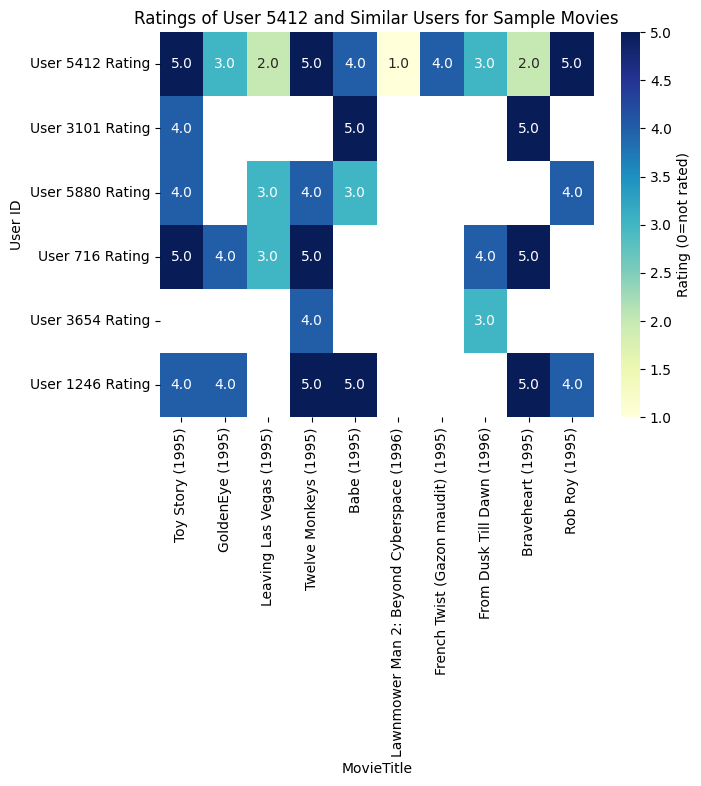

In [19]:
# You could visualize this DataFrame as a heatmap or bar chart if needed
# For example, a heatmap:
plt.figure(figsize=(7, 5))
sns.heatmap(rating_df.set_index('MovieTitle').T.replace(0, np.nan), annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': 'Rating (0=not rated)'})
plt.title(f'Ratings of User {sample_user_id} and Similar Users for Sample Movies')
plt.ylabel('User ID')
plt.show()




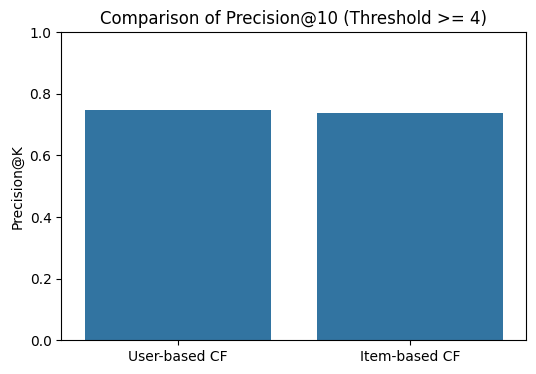

In [20]:
models = ['User-based CF', 'Item-based CF']
precision_values = [precision_at_10_user, precision_at_10_item]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=precision_values)
plt.title(f'Comparison of Precision@{10} (Threshold >= {relevance_threshold})')
plt.ylabel('Precision@K')
plt.ylim(0, 1) # Precision is between 0 and 1
plt.show()